In [1]:
flex_source_link = "https://github.com/et22"

In [91]:
import seaborn as sns
import pandas as pd
import numpy as np
import ipywidgets as widgets
from scipy.io import loadmat
from IPython.display import display, Markdown, clear_output
from ipywidgets import interact
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import ipywidgets as widgets
from IPython.display import clear_output, display
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial.distance import euclidean

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

np.random.seed(42)


In [3]:
def make_cont_mtx(cat_row, cat_col, cont, num_rows):
    cat_rows = np.arange(num_rows)+1
    cat_cols = np.arange(num_rows)+1
    cont_mtx = np.zeros((cat_rows.size, cat_cols.size))
    for idxr, row in np.ndenumerate(cat_rows):
        for idxc, col in np.ndenumerate(cat_cols):
            cont_mtx[idxr, idxc] = np.nanmean(cont[np.logical_and(cat_row == row,cat_col == col)]);
    return cont_mtx;

def make_prop_mtx(cat_row, cat_col, numer_var, num_rows):
    cat_rows = np.arange(num_rows)+1
    cat_cols = np.arange(num_rows)+1
    prop_numer = np.zeros((cat_rows.size, cat_cols.size))
    prop_denom = np.zeros((cat_rows.size, cat_cols.size))
    for idxr, row in np.ndenumerate(cat_rows):
        for idxc, col in np.ndenumerate(cat_cols):
            subset = np.logical_and(cat_row == row,cat_col == col)
            rev_subset = np.logical_and(cat_row == col, cat_col == row)
            either_subset = np.logical_or(subset, rev_subset)
            prop_numer[idxr, idxc] = np.nansum(numer_var[subset])
            prop_denom[idxr, idxc] = np.size(numer_var[subset])
            
    prop_mtx = np.divide(prop_numer, prop_denom)
    return prop_mtx, prop_numer, prop_denom

def get_checkbox_inclusions(boxes, pre_tlabels, post_tlabels):
    subset = np.ones_like(pre_tlabels, dtype='bool')
    for idx, box in enumerate(boxes):
        if not box.value:
            ex_val = idx + 1
            subset = np.logical_and.reduce((subset, pre_tlabels!=ex_val, post_tlabels!=ex_val))
    return subset
            
def get_subset(change):
    metric = ccg_selection.value
    
    maxima = maxima_selection.value
    lag_max = lag_selection.value[1]
    lag_min = lag_selection.value[0]
    
    std_max = std_selection.value[1]
    std_min = std_selection.value[0]
    
    area_max = area_selection.value[1]
    area_min = area_selection.value[0]
    
    
    
    ccg_curr = ccg_data[metric][0][0].copy()
    ccg_fields = ccg_data['ccg'][0][0].dtype.names
    
    lag_subset = np.logical_and(ccg_curr[maxima+'_lag']>=lag_min, ccg_curr[maxima+'_lag']<=lag_max)
    maxima_subset = np.logical_and(ccg_curr[maxima+'s']>=(std_min*ccg_curr['noise_std']+ccg_curr['noise_mean']), ccg_curr[maxima+'s']<=(std_max*ccg_curr['noise_std']+ccg_curr['noise_mean'])) 
    area_subset = np.logical_and(ccg_curr['area']>=area_min, ccg_curr['area']<=area_max)    
    
    cl_subset = get_checkbox_inclusions(cl_checkboxes[1:],ccg_curr['pre_cl'],ccg_curr['post_cl'])
    ct_subset = get_checkbox_inclusions(ct_checkboxes[1:],ccg_curr['pre_ct'],ccg_curr['post_ct'])
    sc_subset = get_checkbox_inclusions(sc_checkboxes[1:],ccg_curr['pre_sc'],ccg_curr['post_sc'])

    subset = np.logical_and.reduce((lag_subset, maxima_subset, area_subset, cl_subset, ct_subset, sc_subset))
    
    for field in ccg_fields:
        if field != 'config' and field != 'cluster':
            ccg_curr[field] = ccg_curr[field][np.squeeze(subset)]
            
    return ccg_curr, maxima, metric, subset 

In [135]:
def cluster(ccgs, weights, range_n_clusters):
    score = []
    inertia = []
    for k in range_n_clusters:
        cluster_obj = MiniBatchKMeans(n_clusters=k, compute_labels=True)
        cluster_labels = cluster_obj.fit_predict(ccgs, sample_weight=weights)
        if k>1:
            silhouette_samps = silhouette_samples(ccgs, cluster_labels)
            sihouette_score=np.average(silhouette_samps, weights=weights)
        else:
            sihouette_score=0
        score.append(sihouette_score)
        inertia.append(cluster_obj.inertia_)
    return score, inertia



In [25]:
ccg_data = loadmat('int_output/combined_ccg_data.mat', chars_as_strings=True)

In [26]:
ccg_data = ccg_data['ccg_data'][0][0]

In [ ]:
ccgs = ccg_data['ccg'][0][0]['ccg_control'][:,90:101]
peaks = ccg_data['ccg'][0][0]['peaks']
troughs = ccg_data['ccg'][0][0]['troughs']
noise_mean = ccg_data['ccg'][0][0]['noise_mean']
noise_std = ccg_data['ccg'][0][0]['noise_std']

ccgs = (ccgs-np.min(ccgs))/np.ptp(ccgs)
weights = np.squeeze(np.maximum(np.zeros_like(peaks),(peaks-noise_mean)/noise_std) + np.maximum(np.zeros_like(peaks),(noise_mean-troughs)/noise_std))
weights[np.isnan(weights)] = 0

range_n_clusters = [1,2,3,4,5,6,7,8,9,10]
score, inertia = cluster(ccgs, weights, range_n_clusters)
plt.plot(range_n_clusters, score)
plt.show()
plt.plot(range_n_clusters, inertia)

In [131]:
# define cat variable labels
labels = {'cl': ["2/3", "4a/b", "4cα", "4cβ", "5", "6", "WM"], 
         'sc': ["Complex", "Simple"],
         'ct': ["AS", "FS", "RM", "RL"]}

# Sidebar

### Input

In [8]:
# code
ccg_label = widgets.Label(value="Metric:")
ccg_selection = widgets.RadioButtons(
    options=[('p(post|coinc.)', 'ccgn'),('p(post|pre)', 'ccg'), ('p(post|not pre)','nccg'), ('p(post|pre)-p(post|not pre)','diffccg'), ('MI(pre, post)','miccg')],
    value='ccg',
    disabled=False
)
maxima_label = widgets.Label(value="Excite/Inhibit:")
maxima_selection = widgets.RadioButtons(
    options=[('peaks', 'peak'), ('troughs', 'trough')],
    value='peak',
    disabled=False
)
std_label = widgets.Label(value="Noise Std:")
std_selection = widgets.FloatRangeSlider(
    value=[3, 10],
    min=-10.0,
    max=10.0,
    step=0.1,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
lag_label = widgets.Label(value="Tau:")
lag_selection = widgets.IntRangeSlider(
    value=[0, 10],
    min=0,
    max=10,
    step=1,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
area_label = widgets.Label(value="Area:")
area_selection = widgets.FloatRangeSlider(
    value=[.05, .5],
    min=-.5,
    max=.5,
    step=.01,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

cl_label = widgets.Label(value="Layer:")
cl_checkboxes = [widgets.Checkbox(value=True, indent=False, description=label) for label in labels['cl']]
cl_checkboxes[6].value = False; # don't include WM in default layers
cl_checkboxes.insert(0,cl_label);
cl_selection = widgets.VBox(children=cl_checkboxes)

ct_label = widgets.Label(value="Putat. type:")
ct_checkboxes = [widgets.Checkbox(value=True, indent=False, description=label) for label in labels['ct']]
ct_checkboxes.insert(0,ct_label);
ct_selection = widgets.VBox(children=ct_checkboxes)

sc_label = widgets.Label(value="Func. type:")
sc_checkboxes = [widgets.Checkbox(value=True, indent=False, description=label) for label in labels['sc']]
sc_checkboxes.insert(0,sc_label);
sc_selection = widgets.VBox(children=sc_checkboxes)
ex_selection = widgets.HBox([cl_selection, ct_selection, sc_selection])

plot_label = widgets.Label(value="Plot by:")
plot_selection = widgets.RadioButtons(
    options=[('Layer', 'cl'), ('Putative cell type', 'ct'), ('Functional cell type', 'sc')],
    value='cl',
    disabled=False
)

widgets.VBox([ccg_label, ccg_selection, maxima_label, maxima_selection, std_label, std_selection,lag_label,
              lag_selection, area_label, area_selection, ex_selection, plot_label, plot_selection])


In [9]:
# code
pre_pair_label = widgets.Label(value="Pre:")
pre_opt = [(label, idx+1) for idx, label in enumerate(labels[plot_selection.value])]
pre_pair_selection = widgets.RadioButtons(
    options=pre_opt,
    value=pre_opt[0][1],
    disabled=False
)
post_pair_label = widgets.Label(value="Post:")
post_opt =  [(label, idx+1) for idx, label in enumerate(labels[plot_selection.value])]
post_pair_selection = widgets.RadioButtons(
    options=post_opt,
    value=post_opt[0][1],
    #layout={'width': 'max-content'},
    disabled=False
)

![Moore Lab](https://static.wixstatic.com/media/2997bf_9718a381f05f4cc9a721428ad26c6639~mv2.jpeg/v1/crop/x_35,y_47,w_1223,h_614/fill/w_388,h_195,al_c,q_80,usm_0.66_1.00_0.01/Image%207-17-20%20at%203_45%20PM.webp)

# |Tau| Heatmap

## Column 1

### Output

In [10]:
out = widgets.Output()
outs = widgets.Output()
outsi = widgets.Output()

out2 = widgets.Output()
out2s = widgets.Output()
out2si = widgets.Output()

out3 = widgets.Output()
out3s = widgets.Output()
out3si = widgets.Output()

out4 = widgets.Output()
out4s = widgets.Output()
out4si = widgets.Output()


def on_value_change(change):
    ccg_curr, maxima, metric, subset  = get_subset(change)
    plot_type = plot_selection.value;
    row_labels = labels[plot_type]
    num_rows = len(row_labels);
    pre_lab = "pre_" + plot_type
    post_lab = "post_" + plot_type
    
    with out:
        cont_mtx = make_cont_mtx(ccg_curr[pre_lab], ccg_curr[post_lab], ccg_curr[maxima+'_lag'], num_rows)
        df = pd.DataFrame(cont_mtx, columns=row_labels, index=row_labels)
        
        out.clear_output(wait=True)
        sns.heatmap(df, annot=True)
        plt.xlabel('post-syn. neuron')
        plt.ylabel('pre-syn. neuron')
        plt.title("mean lead (ms), n = " + str(ccg_curr[pre_lab].size))
        plt.show()
    
    with out2:
        cont_mtx = make_cont_mtx(ccg_curr[pre_lab], ccg_curr[post_lab], ccg_curr[maxima+'s'], num_rows)
        df = pd.DataFrame(cont_mtx, columns=row_labels, index=row_labels)
        
        out2.clear_output(wait=True)
        sns.heatmap(df, cmap='YlOrBr', annot=True)
        plt.xlabel('post-syn. neuron')
        plt.ylabel('pre-syn. neuron')
        plt.title("mean maxima (ms), n = " + str(ccg_curr[pre_lab].size))
        plt.show()
        
    with out3:
        mtx, numer, denom = make_prop_mtx(ccg_curr[pre_lab], ccg_curr[post_lab], ccg_curr['peak_lag']>-1, num_rows)
        prop_mtx = np.divide(numer, numer + np.transpose(numer));
        df = pd.DataFrame(prop_mtx, columns=row_labels, index=row_labels)
        
        out3.clear_output(wait=True)
        sns.heatmap(df, cmap='vlag', center=.5, annot=True) #, annot=True
        plt.xlabel('neuron k')
        plt.ylabel('neuron j')
        plt.title("prop. j leads k, n = " + str(ccg_curr[pre_lab].size))
        plt.show()
    
    with out4:
        ccg_pre_subset = ccg_data[metric][0][0].copy()
        mtx, numer, denom = make_prop_mtx(ccg_pre_subset[pre_lab], ccg_pre_subset[post_lab], subset, num_rows)
        df = pd.DataFrame(mtx, columns=row_labels, index=row_labels)
        
        out4.clear_output(wait=True)
        sns.heatmap(df, cmap='YlOrBr', annot=True) #, annot=True
        plt.xlabel('neuron k')
        plt.ylabel('neuron j')
        plt.title("prop. sig, n = " + str(ccg_curr[pre_lab].size) + "/" + str(ccg_pre_subset[pre_lab].size))
        plt.show()
    
    on_pairwise_change(change)

def on_plot_type_change(change):        
    plot_type = plot_selection.value;    
    pre_opt = [(label, idx+1) for idx, label in enumerate(labels[plot_type])]
    pre_pair_selection.value = pre_opt[0][1]
    pre_pair_selection.options = pre_opt
    
    post_opt = [(label, idx+1) for idx, label in enumerate(labels[plot_type])]
    post_pair_selection.value = post_opt[0][1]
    post_pair_selection.options = post_opt
    
    with outsi:
        outsi.clear_output(wait=True)
        display(widgets.HBox([widgets.VBox([pre_pair_label, pre_pair_selection]), widgets.VBox([post_pair_label, post_pair_selection])]))
    
    with out2si:
        out2si.clear_output(wait=True)
        display(widgets.HBox([widgets.VBox([pre_pair_label, pre_pair_selection]), widgets.VBox([post_pair_label, post_pair_selection])]))
    
    with out3si:
        out3si.clear_output(wait=True)
        display(widgets.HBox([widgets.VBox([pre_pair_label, pre_pair_selection]), widgets.VBox([post_pair_label, post_pair_selection])]))

    with out4si:
        out4si.clear_output(wait=True)
        display(widgets.HBox([widgets.VBox([pre_pair_label, pre_pair_selection]), widgets.VBox([post_pair_label, post_pair_selection])]))
        
    on_pairwise_change(change)

def on_pairwise_change(change):
    ccg_curr, maxima, metric, subset  = get_subset(change)
    plot_type = plot_selection.value;
    row_labels = labels[plot_type]
    num_rows = len(row_labels);
    pre_lab = "pre_" + plot_type
    post_lab = "post_" + plot_type
    
    with outs:
        x1 = np.squeeze(np.logical_and(ccg_curr[pre_lab] == pre_pair_selection.value, ccg_curr[post_lab] ==post_pair_selection.value)); 
        x2 = np.squeeze(np.logical_and(ccg_curr[post_lab] == pre_pair_selection.value, ccg_curr[pre_lab] ==post_pair_selection.value));
        conx_labels = {1: "pre->post", 2: "post->pre", 0: "other"}        
        lag = np.squeeze(ccg_curr[maxima+'_lag'])
        connection = pd.Categorical(np.append(x1, 2*x2)).rename_categories(conx_labels)
        lag = np.append(lag, lag)
        df = pd.DataFrame({'lead':lag, 'connection':connection})
        
        outs.clear_output(wait=True)
        sns.histplot(data=df, x='lead', hue="connection", stat="density", common_norm=False, fill=False)
        plt.show()
    
    with out2s:
        x1 = np.squeeze(np.logical_and(ccg_curr[pre_lab] == pre_pair_selection.value, ccg_curr[post_lab] ==post_pair_selection.value)); 
        x2 = np.squeeze(np.logical_and(ccg_curr[post_lab] == pre_pair_selection.value, ccg_curr[pre_lab] ==post_pair_selection.value));
        conx_labels = {1: "pre->post", 2: "post->pre", 0: "other"}        
        lag = np.squeeze(ccg_curr[maxima+'s'])
        lag = np.append(lag, lag)
            
        connection = pd.Categorical(np.append(x1, 2*x2)).rename_categories(conx_labels)
        df = pd.DataFrame({maxima:lag, 'connection':connection})
        
        out2s.clear_output(wait=True)
        sns.histplot(data=df, x=maxima, hue="connection", stat="density", common_norm=False, fill=False)
        plt.show()
        
    with out3s:
        out3s.clear_output(wait=True)
    
    with out4s:
        out4s.clear_output(wait=True)
        
for cbox in ct_checkboxes:
    cbox.observe(on_value_change, names="value")
for cbox in cl_checkboxes:
    cbox.observe(on_value_change, names="value")
for cbox in sc_checkboxes:
    cbox.observe(on_value_change, names="value")


plot_selection.observe(on_value_change, names="value")
ccg_selection.observe(on_value_change, names="value")
maxima_selection.observe(on_value_change, names="value")
area_selection.observe(on_value_change, names="value")
lag_selection.observe(on_value_change, names="value")
std_selection.observe(on_value_change, names="value")

plot_selection.observe(on_plot_type_change, names="value")

pre_pair_selection.observe(on_pairwise_change, names="value")
post_pair_selection.observe(on_pairwise_change, names="value")

In [11]:
on_value_change(None)
out

Output()

## Column 2

### Pairwise Test Input


In [12]:
on_plot_type_change(None)
outsi

Output()

### Pairwise Test Output

In [13]:
outs


Output()

# Maxima Heatmap

## Column 1

### Output

In [14]:
out2

Output()

## Column 2

### Pairwise Test Input

In [15]:
out2si

Output()

### Pairwise Test Output

In [16]:
out2s

Output()

# Prop. j leads k Heatmap

## Column 1

### Output

In [17]:
out3

Output()

## Column 2

### Pairwise Test Input

In [18]:
out3si

Output()

### Pairwise Test Output

In [19]:
out3s

Output()

# Prop. significant

## Column 1

### Output

In [20]:
out4

Output()

## Column 2

### Pairwise Test Input

In [21]:
out4si

Output()

### Pairwise Test Output

In [22]:
out4s

Output()

# Custom Layer Selection

## Custom Sidebar

### Custom Sidebar

In [23]:
print("input")

input


## Column

### Picker

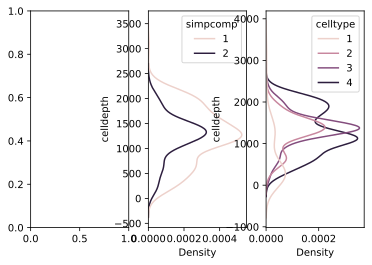

In [24]:
data = ccg_data['ccg'][0][0]['cluster'][0][0]
df = pd.DataFrame({'session': np.squeeze(data['Cluster_session']),
              'celllayer': np.squeeze(data['Cluster_celllayer']),
              'celldepth': np.squeeze(data['Cluster_celldepth']),
               'celltype': np.squeeze(data['Cluster_celltype']), 
              'MI_max': np.squeeze(data['Cluster_MI_max']), 
              'simpcomp': np.squeeze(data['Cluster_simpcomp'])})

plt.subplot(1,3,1)


plt.subplot(1,3,2)
sns.kdeplot(data=df, y="celldepth", hue="simpcomp", fill=False)

plt.subplot(1,3,3)
sns.kdeplot(data=df, y="celldepth", hue="celltype", fill=False)
plt.show()
        